# Preamble

In [2]:
import sys
# pandas to manipulate SQL answer set
import pandas as pd
import time,os
# for Posgresql and other RDBMS
from sqlalchemy import create_engine,event,schema,Table,Column, Integer, Float, String, MetaData, TIMESTAMP, Date, text, inspect
from sqlalchemy_utils import database_exists,create_database
from sqlalchemy.orm import sessionmaker
from sqlalchemy.schema import CreateTable

In [3]:
# change working directory path to that of the current script file
abspath = os.path.abspath("__file__")
dname = os.path.dirname(abspath)
os.chdir(dname)

## Connect to the DB server

In [4]:
# Define your PostgreSQL server connection details
database_name = 'group_7_2024'
username = 'group_7_2024'
password = 'SNMsELrjkpQC'
host = 'dbcourse.cs.aalto.fi'  # or your server address
port = '5432'  # default PostgreSQL port


# Create a connection URL
connection_url = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database_name}'

try:
    # Create an engine to test the connection
    engine = create_engine(connection_url) #.replace(f'/{database_name}', '/postgres'))  # Connect to the default 'postgres' database
    with engine.connect() as conn:
        print("Connection to PostgreSQL server successful.")
except Exception as e:
    print(f"Failed to connect to the PostgreSQL server: {e}")
    exit(1)

# Check if the database already exists
if not database_exists(connection_url):
    # Create the new database
    create_database(connection_url)
    print(f"Database '{database_name}' created successfully.")
else:
    print(f"Database '{database_name}' already exists.")



Connection to PostgreSQL server successful.
Database 'group_7_2024' already exists.


## Check the DB content

In [5]:
# Create an inspector
inspector = inspect(engine)

# Get the list of all tables
tables = inspector.get_table_names()

# Print the tables
print("Tables in the database:")
for table in tables:
    print(table)

Tables in the database:
city
volunteer
volunteer_range
skill
skill_assignment
interest
interest_assignment
beneficiary
request
request_skill
volunteer_application
request_location


## d) Analysis

## 1. Visualization

Queries to generate the data

In [6]:
query_available = " SELECT c.name as city_name, count(distinct vr.volunteer_id) as available_count FROM city as c JOIN volunteer_range as vr ON vr.city_id = c.id GROUP BY c.name ORDER BY count(distinct vr.volunteer_id) DESC"
# joining city and request location by matching city_id, joining the volunteer range on volunteer id
# groupping the data by the name of the city, for which then it is counted how many volunteers are available
# ordering from the cities with most available volunteers

#Executing the query and reading the results into a DataFrame
available_volunteers = pd.read_sql_query(query_available, engine)

query_applied = "SELECT c.name as city_name, count(distinct vr.volunteer_id) as applied_count FROM request_location as rl JOIN city as c ON c.id = rl.city_id JOIN volunteer_application as va ON va.request_id = rl.request_id JOIN volunteer_range as vr ON vr.volunteer_id = va.volunteer_id WHERE rl.city_id  = vr.city_id GROUP BY c.name ORDER BY count(distinct vr.volunteer_id) DESC "
# joining city and request location by matching city_id, joining the volunteer application (to include the info on the applicants) on matching request id, joining the volunteer range on volunteer id
# filtering the rows where the volunteer range actually matches the request location to filter out those who applied but do not match
# groupping the data by the name of the city, for which then it is counted how many volunteers applied
# ordering from the cities with highest number of applicants with suitable skills

#Executing the query and reading the results into a DataFrame
applied_volunteers = pd.read_sql_query(query_applied, engine)


Visualization 1

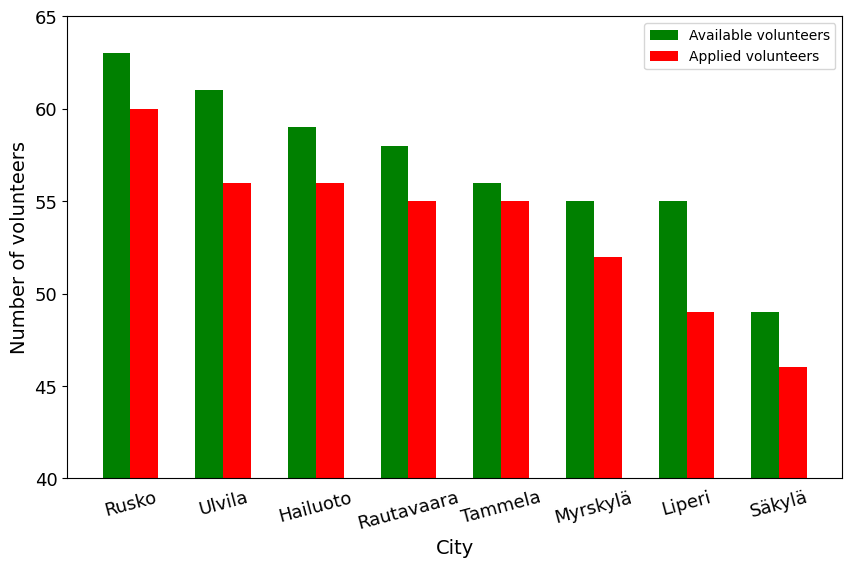

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))  # setting the figure width, height in inches
x = np.arange(len(applied_volunteers['city_name'])) 
bar_width = 0.30 # setting the width of one bar

# Plotting histograms
plt.bar(x - bar_width/2, available_volunteers['available_count'], width=bar_width, color='green', label='Available volunteers')
plt.bar(x + bar_width/2, applied_volunteers['applied_count'], width=bar_width, color='red', label='Applied volunteers')

# Add labels and legend
plt.xlabel('City', fontsize=14)
plt.ylim(40,65)
plt.ylabel('Number of volunteers', fontsize=14) #setting axis label
plt.legend() # add legend
plt.xticks(x, applied_volunteers['city_name'], rotation=15, ha='center', fontsize=13) #add labels of cities under angle in the center of the bar
plt.yticks( fontsize=13) #add labels of cities under angle
plt.gca().xaxis.set_tick_params(which='both', bottom=False, top=False)  # Remove ticks

plt.gcf().set_size_inches(10, 6) 

# Show plot
plt.show()


## Analysis

For each month, what are the number of valid volunteer applications compared to the number of valid requests?

What months have the most and least for each. 

How about the difference between the requests and volunteers for each month? Is there a general/seasonal trend?

Is there any correlation between the time of the year and number of requests and volunteers?

In [8]:
applied = ("""
                   	select month as months_no, count(*)
					from
						(
						select id,
                   			generate_series(extract(month from start_date)::integer, 
                   			extract(month from end_date)::integer) as month
						from
							(
							select
								r.id,
								start_date,
								end_date
							from volunteer_application va
							join request r on va.request_id = r.id
							where va.is_valid = true
                   			) a
                   		) a
					group by
						month
					order by
						month;
					""")
applied_simple = pd.read_sql_query(applied, engine)

requested = ("""select month as months_no,count(*)
           from 
                (select id,generate_series(EXTRACT(MONTH FROM start_date)::integer,EXTRACT(MONTH FROM end_date)::integer) as month
				from request) a 
           group by month
           order by month;""")
requested_simple = pd.read_sql_query(requested, engine)

print(requested_simple)
print(applied_simple)

    months_no  count
0           1     22
1           2     21
2           3     29
3           4     25
4           5     27
5           6     45
6           7     40
7           8     45
8           9     44
9          10     31
10         11     33
11         12     34
    months_no  count
0           1    128
1           2    127
2           3    193
3           4    167
4           5    177
5           6    282
6           7    294
7           8    269
8           9    282
9          10    190
10         11    214
11         12    201


What are the number of valid applications compared to requests for each month?
For each month, there is at least three times higher interest of volunteers than the number of requests.

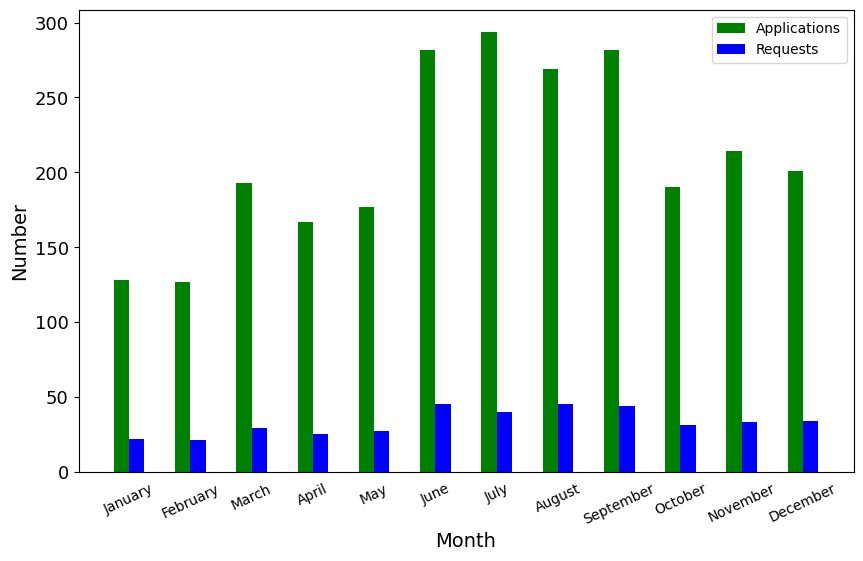

In [11]:
import matplotlib.pyplot as plt
import numpy as np


months_mapping = {1: 'January', 2: 'February', 3: 'March', 4:'April', 5:'May', 6:'June', 7:'July', 8: 'August', 9:'September', 10:'October', 11:'November', 12:'December'}

# Map the numeric values to strings
requested_simple['months'] = requested_simple['months_no'].map(months_mapping)
applied_simple['months'] = applied_simple['months_no'].map(months_mapping)

plt.figure(figsize=(8, 6))  # setting the figure width, height in inches
x = np.arange(len(applied_simple['months'])) 
bar_width = 0.25 # setting the width of one bar

# Plotting histograms
plt.bar(x - bar_width/2, applied_simple['count'], width=bar_width, color='green', label='Applications')
plt.bar(x + bar_width/2, requested_simple['count'], width=bar_width, color='Blue', label='Requests')

# Add labels and legend
plt.xlabel('Month', fontsize=14)
#plt.ylim(40,65)
plt.ylabel('Number', fontsize=14) #setting axis label
plt.legend() # add legend
plt.xticks(x, requested_simple['months'], rotation=25, ha='center', fontsize=10) #add labels of cities under angle in the center of the bar
plt.yticks( fontsize=13) #add labels of cities under angle
plt.gca().xaxis.set_tick_params(which='both', bottom=False, top=False)  # Remove ticks

plt.gcf().set_size_inches(10, 6) 

# Show plot
plt.show()

What months have the most and least for each?
Answer: The smallest number of applications and requests for volunteers is in February, while in Augustu is largest both the demand and supply of volunteers.

    months_no  count     months
1           2    127   February
0           1    128    January
3           4    167      April
4           5    177        May
9          10    190    October
2           3    193      March
11         12    201   December
10         11    214   November
7           8    269     August
5           6    282       June
8           9    282  September
6           7    294       July


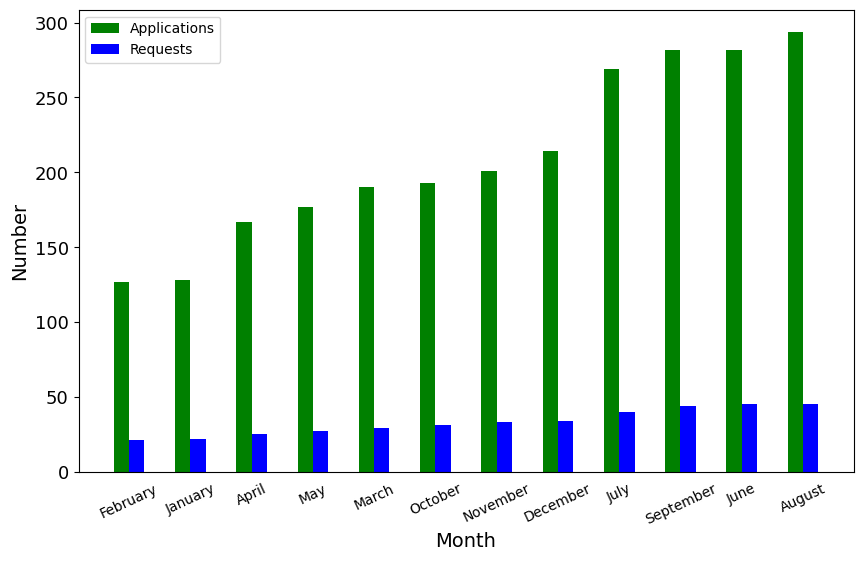

In [12]:
import pandas as pd
requested_df_sorted = requested_simple.sort_values(by='count')
applied_df_sorted = applied_simple.sort_values(by='count')
print(applied_df_sorted)

plt.figure(figsize=(8, 6))  # setting the figure width, height in inches
x = np.arange(len(requested_df_sorted['months'])) 
bar_width = 0.25 # setting the width of one bar

# Plotting histograms
plt.bar(x - bar_width/2, applied_df_sorted['count'], width=bar_width, color='green', label='Applications')
plt.bar(x + bar_width/2, requested_df_sorted['count'], width=bar_width, color='Blue', label='Requests')

# Add labels and legend
plt.xlabel('Month', fontsize=14)
#plt.ylim(40,65)
plt.ylabel('Number', fontsize=14) #setting axis label
plt.legend() # add legend
plt.xticks(x, requested_df_sorted['months'], rotation=25, ha='center', fontsize=10) #add labels of cities under angle in the center of the bar
plt.yticks( fontsize=13) #add labels of cities under angle
plt.gca().xaxis.set_tick_params(which='both', bottom=False, top=False)  # Remove ticks

plt.gcf().set_size_inches(10, 6) 

# Show plot
plt.show()



Is there any correlation between the time of the year and number of requests and volunteers?


Visualization 3 - free choice

In [18]:
age = (""" select EXTRACT(YEAR FROM age(current_date, v.birthdate ::date)) as age
from volunteer v 
join volunteer_application va on v.id = va.volunteer_id
join request r on va.request_id = r.id;				""")

available_volunteers = pd.read_sql_query(age, engine)
print(age)

plt.hist(age, bins=20, edgecolor='red')  # Adjust bins as needed
plt.title('Histogram of age of volunteer')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()





 select EXTRACT(YEAR FROM age(current_date, v.birthdate ::date)) as age
from volunteer v 
join volunteer_application va on v.id = va.volunteer_id
join request r on va.request_id = r.id	;				


## Close connection to the DB

In [14]:
# Dispose of the engine to close the connection
engine.dispose()
print("Connection to PostgreSQL server closed.")

Connection to PostgreSQL server closed.


: 